<h3>Data Wrangling with MongoDB: Final Project</h3>

<h2>Data Wrangling OpenStreetMap Data of a West Sacramento, California</h2>

The area I chose to look at is a subarea of Sacramento, CA, West Sacramento, CA. The map data I am using is from OpenStreetMap. It can be downloaded using the Overpass API in XML format. I will be applying the techniques I learned from Udacity's Data Wrangling with MongoDB to explore, audit, and clean the dataset then convert the xml to JSON. 

West Sacramento, CA is shown as the selected box region below:

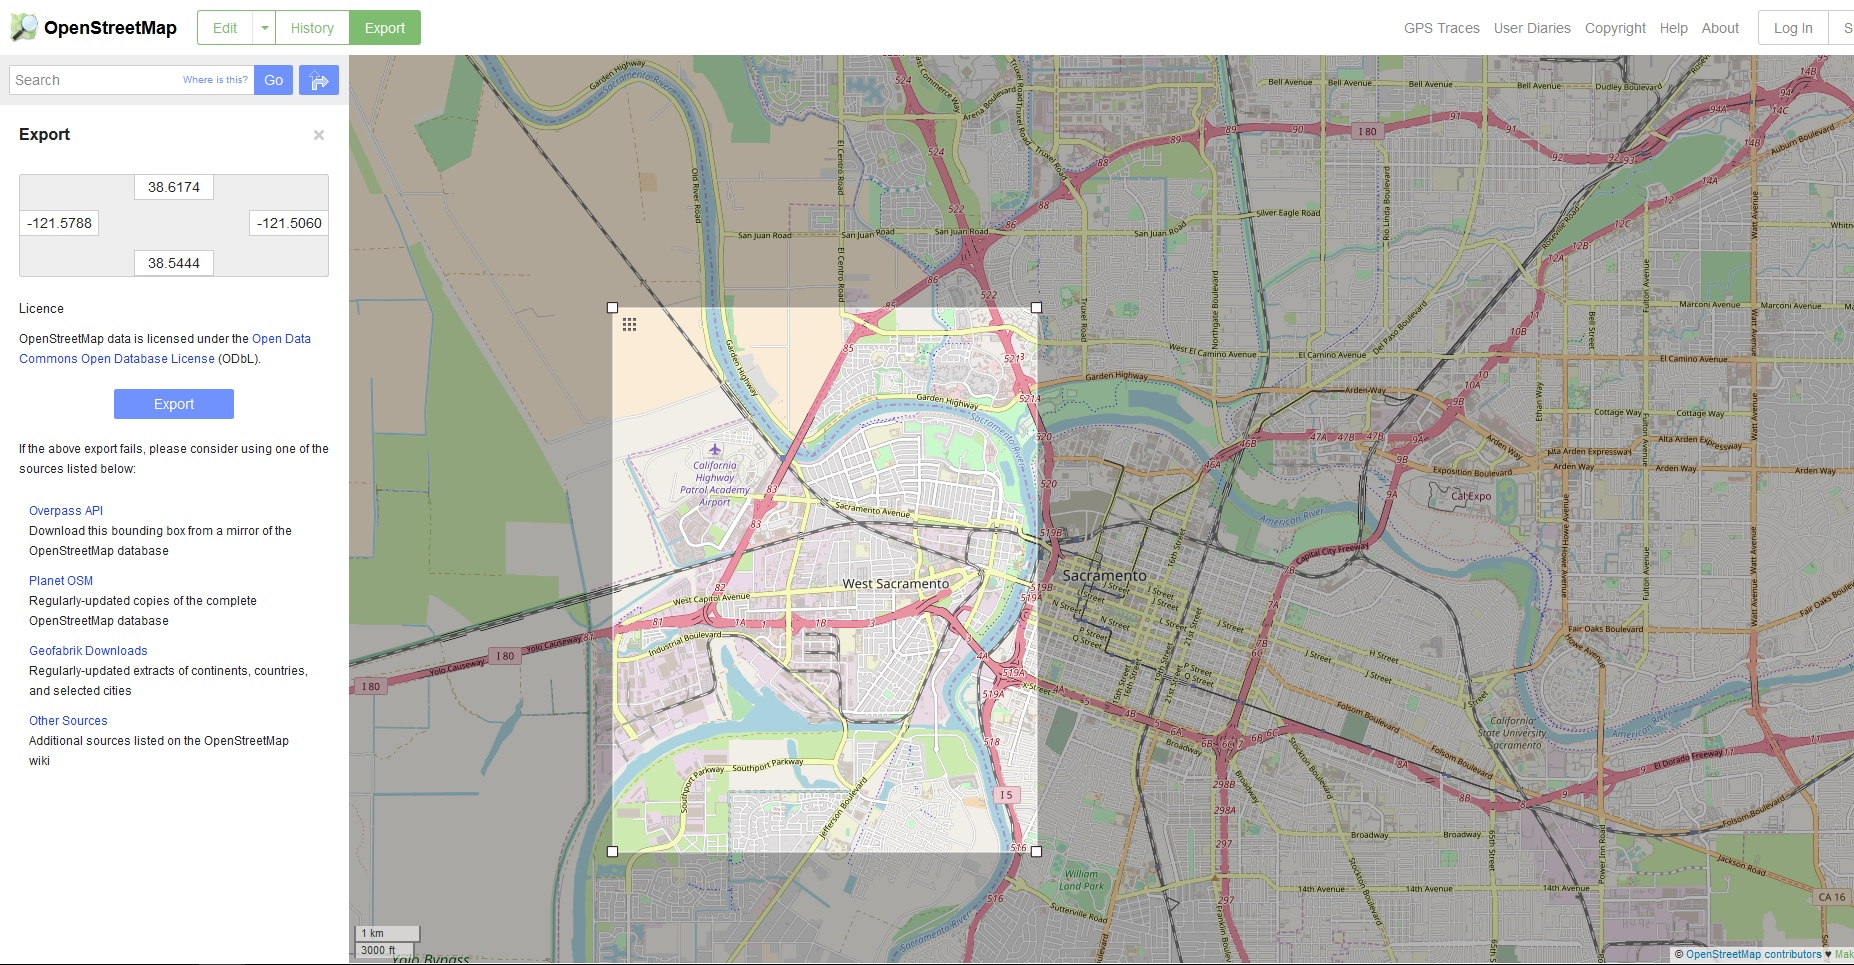

In [85]:
from IPython.display import Image
Image(filename='img1.jpg')

First, the following libraries need to be imported:

In [86]:
import os
import os.path
import sys
import time
import requests
import xml.etree.cElementTree as ET
import pprint
import re
import codecs
import json
from collections import defaultdict

<h2>Generate The Sample Dataset</h2>

First, we need to download the map data using the Overpass API (from OpenStreetMap). The function download_file() takes in the API url and the desired filename, and downloads the map data to the current worked directory. 

In [87]:
url = 'https://overpass-api.de/api/map?bbox=-121.6653,38.4326,-121.2578,38.6906'
filename = 'west_sacramento.osm'

In [88]:
def download_file(url, local_filename):
    """Downloads file needed to start Audit"""
    # stream = True allows downloading of large files; prevents loading entire file into memory
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                f.flush()
                
download_file(url, filename)

<h2>Data Auditing</h2>

In order to audit the dataset and see if there is any potential problems, let's determine the number of elements and the number they occur. This will help us get a better idea of how much of what data is expected. 

Here, the count_tag function is used to return a dict with the tag as the key and the occurrence as the value. 

In [90]:
def count_tags(filename):
    """Returns a dictionary of tags and totals."""
    tags = {}

    for event, elem in ET.iterparse(filename):
        if elem.tag in tags: 
            tags[elem.tag] += 1
        else:                
            tags[elem.tag] = 1
    return tags

tags = count_tags('west_sacramento.osm')
pprint.pprint(tags)

{'bounds': 1,
 'member': 20893,
 'meta': 1,
 'nd': 602512,
 'node': 492592,
 'note': 1,
 'osm': 1,
 'relation': 1754,
 'remark': 1,
 'tag': 399721,
 'way': 78515}


These elements: osm, note, and meta, contain meta of the osm file.
<p>These elements: node, way, and relation, are the basic components of the OpenStreetMap's conceptual data model of the physical world.</p>

Now, we'll check the 'k' value for every tag for three regular expressions: 
- lower: for lowercase letters only that are valid.
- lower_color: for tags with a colon in their names and are valid. 
- problem_chars: for tags that have weird characters
Then through the count_keys function we'll return a count of each of the four tag categories in a dictionary.

In [91]:
import re

lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

def key_type(element, keys):
    """Check tag attributes for errors in formatting"""
    if element.tag == "tag":
        for tag in element.iter('tag'):
            k = tag.get('k')
            if lower.search(k):
                keys['lower'] += 1
            elif lower_colon.search(k):
                keys['lower_colon'] += 1
            elif problemchars.search(k):
                keys['problemchars'] += 1
            else:
                keys['other'] += 1
        
    return keys

def process_map(filename):
    keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
    
    for _, element in ET.iterparse(filename):
        keys = key_type(element, keys)

    return keys

keys = process_map(filename)
pprint.pprint(keys)

{'lower': 179622, 'lower_colon': 216256, 'other': 3843, 'problemchars': 0}


<h2>Problem 1: Inconsistent/Out of Bounds Postal Codes</h2>

Below, we use the count_postcodes function to look at the number of postcodes there are, the occurence of each, and the postcode format. Our goal is to make sure, we use zip codes specific to West Sacramento area: 95605, 95691, 95798, 95799, 95818, 95831, 95899. Multiple places outside this area are found in the dataset.

In [92]:
def count_postcodes(filename):
    """Determines how many and number of postcodes for the filename"""
    postcodes = {}
    for event, elem in ET.iterparse(filename, events=('start', 'end')):
        if event == 'end':
            key = elem.attrib.get('k')
            if key == 'addr:postcode':
                postcode = elem.attrib.get('v')
                if postcode not in postcodes:
                    postcodes[postcode] = 1
                else:
                    postcodes[postcode] += 1
    return postcodes


postcodes = count_postcodes(filename)
sorted_by_occurrence = [(k, v) for (v, k) in sorted([(value, key) for (key, value) in postcodes.items()], reverse=True)]

print 'Postcode values and occurrence in sacramento.osm:\n'
pprint.pprint(sorted_by_occurrence)

Postcode values and occurrence in sacramento.osm:

[('95691', 14989),
 ('95605', 5107),
 ('95841', 201),
 ('95814', 81),
 ('95825', 75),
 ('95818', 74),
 ('95831', 57),
 ('95610', 45),
 ('95833', 42),
 ('95811', 41),
 ('95817', 39),
 ('95821', 38),
 ('95827', 37),
 ('95815', 36),
 ('95835', 32),
 ('95823', 31),
 ('95819', 31),
 ('95816', 31),
 ('95834', 29),
 ('95670', 26),
 ('95822', 24),
 ('95608', 20),
 ('95655', 16),
 ('95820', 13),
 ('95864', 12),
 ('95624', 12),
 ('95742', 11),
 ('95829', 10),
 ('95826', 9),
 ('95758', 9),
 ('95842', 8),
 ('95628', 8),
 ('95832', 7),
 ('95828', 7),
 ('95621', 6),
 ('96816', 5),
 ('95824', 5),
 ('95660', 5),
 ('95838', 3),
 ('95673', 3),
 ('CA 95834', 2),
 ('95837', 2),
 ('95832-1447', 2),
 ('95819-6055', 2),
 ('95652', 2),
 ('95618', 2),
 ('CA 95833', 1),
 ('CA 95832', 1),
 ('CA 95829', 1),
 ('CA 95827', 1),
 ('CA 95826', 1),
 ('CA 95822', 1),
 ('CA 95819', 1),
 ('CA 95655', 1),
 ('CA 95628', 1),
 ('98584', 1),
 ('95826-2625', 1),
 ('95819-6138',

For the most part, the zip codes are largely consistent. Although there are a few zip codes that are in a 9 digit format; and some zip codes with the string 'CA' in front. 

Since we are looking for area codes in west sacramento, the below functions will search for elements not in the zipcodes: 95605, 95691, 95798, 95799, 95818, 95831, 95899 and remove them. Then we will take the original file and create a new file with zip codes in our target area. 

In [93]:
def get_postcode(elem):
    """Returns True if postcode value contains a postcode, 
    or false if the element doesn't"""
    if elem.tag in ['node', 'way', 'relation']:
        for tag in elem.iter():
            if tag.get('k') == 'addr:postcode':
                return True, tag.get('v')
        return False, None
    return False, None


def wsac_postcode(filename, cleaned_filename):
    """Takes original file and returns a new file with cleaned postcodes specific to West Sacramento"""
    tree = ET.parse(filename)
    root = tree.getroot()
    
    for child in ['node', 'way', 'relation']:
        for elem in root.findall(child):
            has_postcode, postcode_value = get_postcode(elem)
            if has_postcode:
                if postcode_value not in ['95605', '95691', '95798', '95799', '95818', '95831', '95899']:
                    root.remove(elem)
    
    return tree.write(cleaned_filename)

ws_postcode = 'ws_postcode.xml' #Name of "new" file
wsac_postcode(filename, ws_postcode)

In [94]:
postcodes = count_postcodes(ws_postcode)
sorted_by_occurrence = [(k, v) for (v, k) in sorted([(value, key) for (key, value) in postcodes.items()], reverse=True)]

print 'Postcode values and occurrence after cleaning:\n'
pprint.pprint(sorted_by_occurrence)

Postcode values and occurrence after cleaning:

[('95691', 14989), ('95605', 5107), ('95818', 74), ('95831', 57)]


<h2>Problem 2: Abbreviated Street Names</h2>

By looking through the dataset, there are inconsistencies in the street name abbreviations. 

The goal is to unify the street types to a single representation:

- 21st St. => 21st Street
- 2nd St Suite 330 => 2nd Street

In order to do this we've set a variable mapping which mirrors the changes to fix the inconsistencies of the street types. 

The <em>update_name()</em> function fixes the street name. It takes in a string (the street name to be fixed) as an argument and returns the corresponding fix from mapping.


In [95]:
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)

expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", "Square", "Lane", "Road", 
            "Trail", "Parkway", "Commons"]

# UPDATE THIS VARIABLE
mapping = { "pl": "Place",
            "st": "Street",
            "ave": "Avenue",
            "rd": "Road",
            "w": "West",
            "n": "North",
            "s": "South",
            "e": "East",
            "blvd":"Boulevard",
            "ic": "Interchange",
            "sr": "Drive",
            "ct": "Court",
            "ne": "Northeast",
            "se": "Southeast",
            "nw": "Northwest",
            "sw": "Southwest",
            "dr": "Drive",
            "sq": "Square",
            "ln": "Lane",
            "trl": "Trail",
            "pkwy": "Parkway",
            "ste": "Suite",
            "lp": "Loop",
            "hwy": "Highway"}


def audit_street_type(street_types, street_name):
    """Update dictionary of street names and mapping type"""
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)


def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")


def audit(osmfile):
    osm_file = open(osmfile, "r")
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(osm_file, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])

    return street_types


def update_name(name, mapping):
    """Replace and return new name from street name mapping."""
    name_list = re.findall(r"[\w']+", name)
    end_of_street_name = len(name_list)
    
    for i in range(len(name_list)):
        word = name_list[i].lower()
        if word in mapping:
            end_of_street_name = i
            name_list[i] = mapping[word]
        
    name_list = name_list[:(end_of_street_name+1)]
    better_name = ' '.join(name_list)
    return better_name

In [96]:
street_types = audit(ws_postcode)

for st_type, ways in street_types.iteritems():
    for name in ways:
        better_name = update_name(name, mapping)
        if name != better_name:
            print name, "=>", better_name

Hamilton St. => Hamilton Street
Paladena St. => Paladena Street
Pasadena St. => Pasadena Street
21st St. => 21st Street
S. Power Inn Rd => South Power Inn Road
Creek Rd. => Creek Road
Garden Oak Ct. => Garden Oak Court
Southport P PKWY => Southport P Parkway
Ponderay Ln. => Ponderay Lane
Carle Ln. => Carle Lane
Banfield Dr => Banfield Drive
Pasadena Ave => Pasadena Avenue
Manzanita Ave => Manzanita Avenue
Ne Quad Enterprise Dr / I-80 Ic @ Capitol Ave => Northeast Quad Enterprise Drive I 80 Interchange Capitol Avenue
Orange Grove Ave. => Orange Grove Avenue
Myrtle Ave. => Myrtle Avenue
Pasadena Ave. => Pasadena Avenue
Watt Ave. => Watt Avenue
Fair Oaks Boulevard, Fair Oaks, CA 95628-7416 => Fair Oaks Boulevard Fair Oaks CA 95628 7416
Northgate Blvd. => Northgate Boulevard
Freeport Blvd. => Freeport Boulevard
Rio Linda Blvd => Rio Linda Boulevard
Folsom Blvd => Folsom Boulevard
Franklin Blvd => Franklin Boulevard
Sw Quad Enterprise Dr / I-80 Ic => Southwest Quad Enterprise Drive I 80 Int

In [99]:
def better_street_names(filename, cleaned_filename):
    """Takes original file and returns a new file with 
    cleaned street names specific to West Sacramento"""
    tree = ET.parse(filename)
    root = tree.getroot()

    for tag in root.findall('*/tag'):
        if is_street_name(tag):
            name = tag.get('v')
            better_name = update_name(name, mapping)
            tag.set('v', better_name)

    return tree.write(cleaned_filename)

ws_street_name = 'ws_street_name.xml' #Name of "new" file
better_street_names(ws_postcode, ws_street_name)

In [100]:
street_types = audit(ws_street_name)

for st_type, ways in street_types.iteritems():
    for name in ways:
        better_name = update_name(name, mapping)
        if name != better_name:
            print name, "=>", better_name

<h2>Preparing the Database</h2>

Now that auditing is assumed to be complete, one must prepare to insert the information into a MongoDB. To do so, the data has to be transfer into jason documents structured like this:

    {
        "id": "2406124091",
        "type: "node",
        "visible":"true",
        "created": {
                      "version":"2",
                      "changeset":"17206049",
                      "timestamp":"2013-08-03T16:43:42Z",
                      "user":"linuxUser16",
                      "uid":"1219059"
                   },
        "pos": [41.9757030, -87.6921867],
        "address": {
                      "housenumber": "312",
                      "postcode": "95632",
                      "street": "North Pearson Street"
                   },
        "amenity": "restaurant",
        "cuisine": "mexican",
        "name": "La Taqueria",
        "phone": "916 271 5276"
    }

The transform will follow these rules:
- Process only 2 top level tags: node & way
- All node and way attributes will be turned into key/value pairs with the exception of:
    - The following attributes will be added under a key created: version, changeset, timestamp, user, uid
    - Latitude and longitude attributes should be added to a pos array (geographical indexing). These values must be floats, not strings. 
- If second level tag "k" value contains problematic characters, it should be ignored
- If second level tag "k" value starts with "addr:", it should be added to a dictionary address
- If second level tag "k" value does not start with "addr:", but contains ":", you can process it same as any other tag.
- If there is a second ":" that separates the type/direction of a street, the tag should be ignored, for example:
    <tag k="addr:housenumber" v="5158"/>
    <tag k="addr:street" v="North Lincoln Avenue"/>
    <tag k="addr:street:name" v="Lincoln"/>
    <tag k="addr:street:prefix" v="North"/>
    <tag k="addr:street:type" v="Avenue"/>
    <tag k="amenity" v="pharmacy"/>

should be turned into:

    {
      "address": {
                     "housenumber": 5158,
                     "street": "North Lincoln Avenue"
                 },
      "amenity": "pharmacy"
    }

For "way" specifically:

    <nd ref="305896090"/>
    <nd ref="1719825889"/>

should be turned into:

    {
      "node_refs": ["305896090", "1719825889"]
    }
    
A function named shape_element will be used to transform the data based on above. This function will have an update function that regexes and maps the dictionaries defined above to clean street addresses.

In [102]:
def shape_element(element):
    """
    Parse, validate and format node and way xml elements.
    Return list of dictionaries
    Keyword arguments:
    element -- element object from xml element tree iterparse
    """
    if element.tag == 'node' or element.tag == 'way':

        # Add empty created dictionary and k/v = type: node/way
        node = {'created': {}, 'type': element.tag}

        # Update pos array with lat and lon
        if 'lat' in element.attrib and 'lon' in element.attrib:
            node['pos'] = [float(element.attrib['lat']), float(element.attrib['lon'])]

        # Deal with node and way attributes
        for k in element.attrib:

            if k == 'lat' or k == 'lon':
                continue
            if k in CREATED:
                node['created'][k] = element.attrib[k]
            else:
                # Add direct key/value items of node/way
                node[k] = element.attrib[k]

        # Deal with second level tag items
        for tag in element.iter('tag'):
            k = tag.attrib['k']
            v = tag.attrib['v']

            # Search for problem characters in 'k' and ignore them
            if problemchars.search(k):
                # Add to array to print out later
                continue
            elif k.startswith('addr:'):
                address = k.split(':')
                if len(address) == 2:
                    if 'address' not in node:
                        node['address'] = {}
                    node['address'][address[1]] = v
            else:
                node[k] = v

        # Add key/value node ref from way
        node_refs = []
        for nd in element.iter('nd'):
            node_refs.append(nd.attrib['ref'])

        if len(node_refs) > 0:
            node['node_refs'] = node_refs

        return node
    else:
        return None

In [103]:
def process_map(file_in, pretty=False):
    # You do not need to change this file
    file_out = "{0}.json".format(file_in)
    data = []
    with codecs.open(file_out, "w") as fo:
        for _, element in ET.iterparse(file_in):
            el = shape_element(element)
            if el:
                data.append(el)
                if pretty:
                    fo.write(json.dumps(el, indent=2) + "\n")
                else:
                    fo.write(json.dumps(el) + "\n")
    return data

data = process_map('ws_street_name.xml')

In [104]:
pprint.pprint(data[0])

{'created': {'changeset': '12304957',
             'timestamp': '2012-07-19T02:21:45Z',
             'uid': '722137',
             'user': 'OSMF Redaction Account',
             'version': '3'},
 'id': '31959070',
 'pos': [38.2354196, -121.6722175],
 'type': 'node'}


Now, we must parse the XML, shape the elements, and write to JSON.

<h2>Data Overview</h2>

In [105]:
filename = 'ws_street_name.xml'
print 'The downloaded file is {} MB'.format(os.path.getsize(filename)/1.0e6) # convert from bytes to megabytes

The downloaded file is 122.084313 MB


In [106]:
print 'The json file is {} MB'.format(os.path.getsize(filename + ".json")/1.0e6) # convert from bytes to megabytes

The json file is 131.158773 MB


In [108]:
def aggregate(db, pipeline):
    return [doc for doc in west_sac.aggregate(pipeline)]

<h2>Working with MongoDB</h2>

In [73]:
from pymongo import MongoClient

mongodb_host = 'localhost'
mongodb_port = '27017'
db_name = 'west_sacramento'

client = MongoClient(mongodb_host +':'+ mongodb_port)
db = client[db_name]

print db

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), u'west_sacramento')


In [74]:
import subprocess

collection = filename[:filename.find('.')]

working_directory = r'"C:\\Users\\Admin\\Downloads\\'
json_file = filename + '.json"'

print working_directory + json_file

mongoimport_cmd = 'C:\\mongodb\\bin\\mongoimport.exe -h 127.0.0.1:27017 ' + \
                  '--db ' + db_name + \
                  ' --collection ' + collection + \
                  ' --file ' + working_directory + json_file

# Before importing, drop collection if it exists (i.e. a re-run)
if collection in db.collection_names():
    print 'Dropping collection: ' + collection
    db[collection].drop()
    
# Execute the co
print 'Executing: ' + mongoimport_cmd

#mongoimport_cmd = "dir"
subprocess.call(mongoimport_cmd.split())

"C:\\Users\\Admin\\Downloads\\ws_street_name.xml.json"
Dropping collection: ws_street_name
Executing: C:\mongodb\bin\mongoimport.exe -h 127.0.0.1:27017 --db west_sacramento --collection ws_street_name --file "C:\\Users\\Admin\\Downloads\\ws_street_name.xml.json"


0

<h2>Investigating the Data</h2>

Once imported, retrieve the collection from the database.

In [113]:
west_sac = db[collection]

<strong>Number of Elements</strong>

In [114]:
west_sac.find().count()

570073

<strong>Number of Unique Users</strong>

In [115]:
len(west_sac.distinct('created.user'))

712

<strong>Number of Nodes</strong>

In [116]:
west_sac.find({'type':'node'}).count()

492137

<strong>Number of Ways</strong>

In [117]:
west_sac.find({'type': 'way'}).count()

77930

<strong>Top 10 Contributing Users</strong>

In [118]:
top_10_users = [
    {'$group': {'_id': '$created.user', 'count': {'$sum': 1}}},
    {'$sort': {'count': -1}},
    {'$limit': 10}]
result = aggregate(db, top_10_users)
pprint.pprint(result)

[{u'_id': u'woodpeck_fixbot', u'count': 96939},
 {u'_id': u'nmixter', u'count': 55287},
 {u'_id': u'jraller', u'count': 29794},
 {u'_id': u'balcoath', u'count': 25960},
 {u'_id': u'muziriana', u'count': 23838},
 {u'_id': u'Eureka gold', u'count': 23196},
 {u'_id': u'marthaleena', u'count': 17690},
 {u'_id': u'tkmedia', u'count': 17548},
 {u'_id': u'bhavana naga', u'count': 17345},
 {u'_id': u'animeigo', u'count': 17127}]


<h1>Additional Ideas</h1>

<strong>Users Appearing Only Once</strong>

In [119]:
users_appearing_once = [
    {'$group': {'_id': '$created.user', 'count': {'$sum':1}}},
    {'$group': {'_id': '$count', 'num_users': {'$sum':1}}},
    {'$sort': {'_id': 1}},
    {'$limit': 1}]
result = aggregate(db, users_appearing_once)
pprint.pprint(result)

[{u'_id': 1, u'num_users': 90}]


<strong>Top 10 Amentities</strong>

In [120]:
most_common_amenities = [
    {'$match': {'amenity': {'$exists': 1}}},
    {'$group': {'_id': '$amenity', 'count': {'$sum': 1}}},
    {'$sort': {'count': -1}},
    {'$limit': 10}]
result = aggregate(db, most_common_amenities)
pprint.pprint(result)

[{u'_id': u'parking', u'count': 1046},
 {u'_id': u'school', u'count': 462},
 {u'_id': u'place_of_worship', u'count': 428},
 {u'_id': u'restaurant', u'count': 195},
 {u'_id': u'fast_food', u'count': 163},
 {u'_id': u'fuel', u'count': 104},
 {u'_id': u'cafe', u'count': 61},
 {u'_id': u'fire_station', u'count': 59},
 {u'_id': u'toilets', u'count': 50},
 {u'_id': u'bank', u'count': 45}]


<strong>Top 20 Food Genres</strong>

In [121]:
top_20_food_genres = [
    {'$match': {'amenity': 'restaurant', 'cuisine': {'$exists': 1}}},
    {'$group': {'_id': '$cuisine', 'count': {'$sum': 1}}},
    {'$sort': {'count': -1}},
    {'$limit': 20}]
result = aggregate(db, top_20_food_genres)
pprint.pprint(result)

[{u'_id': u'mexican', u'count': 15},
 {u'_id': u'pizza', u'count': 13},
 {u'_id': u'chinese', u'count': 10},
 {u'_id': u'american', u'count': 8},
 {u'_id': u'italian', u'count': 7},
 {u'_id': u'thai', u'count': 6},
 {u'_id': u'burger', u'count': 6},
 {u'_id': u'asian', u'count': 5},
 {u'_id': u'japanese', u'count': 4},
 {u'_id': u'sandwich', u'count': 4},
 {u'_id': u'regional', u'count': 3},
 {u'_id': u'chicken', u'count': 2},
 {u'_id': u'indian', u'count': 2},
 {u'_id': u'french', u'count': 2},
 {u'_id': u'smoothies', u'count': 1},
 {u'_id': u'mongolian', u'count': 1},
 {u'_id': u'international', u'count': 1},
 {u'_id': u'nepalese', u'count': 1},
 {u'_id': u'Crepes', u'count': 1},
 {u'_id': u'iranian', u'count': 1}]


<strong>Top 10 Banks</strong>

In [122]:
top_10_banks = [
    {'$match': {'amenity': 'bank'}}, 
    {'$group': {'_id': '$name', 'count': {'$sum': 1}}},
    {'$sort': {'count': -1}}, 
    {'$limit': 10}]
result = aggregate(db, top_10_banks)
pprint.pprint(result)

[{u'_id': u'Bank of America', u'count': 13},
 {u'_id': u'Chase', u'count': 9},
 {u'_id': u'Wells Fargo', u'count': 7},
 {u'_id': u'US Bank', u'count': 4},
 {u'_id': u'Citibank', u'count': 2},
 {u'_id': u'Golden 1 Credit Union', u'count': 2},
 {u'_id': u'Big Valley Federal Credit Union', u'count': 1},
 {u'_id': u'SAFE Credit Union', u'count': 1},
 {u'_id': u'Advantis Credit Union', u'count': 1},
 {u'_id': u'The Golden 1', u'count': 1}]


<h3>Encouraging users to be more active creators</h3>

There's a significant difference in the Sacramento dataset between the highest contributor and the 10th highest contributor in terms of contributions to the dataset. There is a 5.66 difference between the highest and 10th highest contributor. With such a disparity between the top 10 contributors, it's hard to imagine that newer users would even want to contribute. 

So, how can we increase contributions on both a large and small scale?

One of the major changes could be creating a gamification platform whether through achieving a specific challenge goal (being a top 10 contributer to a sub-amenity sub-categories, e.g. adding additional restaurants in a specific cuisine) or by rewarding you for contributing overall similar to Khan Academy (complete a certain number of exercises, and you are rewarded for it). In Open Street Map, exercises would simply be overall number of contributions with bench marks for say 10, 50, 100, 500, 1000, etc. contributions. 

There also must be a checks and balance approach that helps users understand the difference between a bad, good, great, and excellent contribution. This too can be added to the gamification platform; getting users to a higher degree of mastery in their contributions, while also helping increase the overall quality of contributions across the board. 

<h3>Improving the Contribution Map Data Documentation</h3>

To add to encouraging users to be more active creators, developing better documentation in a more step by step format can easily help users become successful sooner and faster when it comes to encouraging contributions. Part of the issue is wading through the documentation for the gist of what is needed to create a decent contribution versus having more of a road map that allows you to clearly develop your contribution skills. 

Part of the issue is documentation as it is, is heavily engrained as part of the developers tool-kit where on must learn how to wade through the information for the necessary information. Developing a simpler process of navigation, and must know steps; goes a long way in getting users motivated initially where many often crumble, especially newer users.

<h3>Standardizing Contributions</h3>

One of the issues in any Data Analysis, is the lack of standardization of data. In this case, how can Open Street Map standardize contribution inputs whether for cities, zip codes, telephone numbers, etc., to allow less data wrangling and more data analysis. 

Of course, standardizing data inputs aren't easy either, but there's certain regulations used in each country that can be followied to allows first for most contributions to be accepted. Afterwards, increased functionality can be added for more rarer input cases to be accepted. 

<h2>Conclusion</h2>

How do we not only increase contributions, but make sure those contributions are of a higher quality? 

Understanding that data is majorly affected in two ways: 
1. How does a user understand and input the data?
2. How do we want the data to be standardized for ease of analysis?

This also creates another question of: Is their a way to marry the user's understanding of input with the standard input for analysis?

People understand data different from each other, whether culturally, environmentally, socially, etc. By creating a platform that allows a user to move from their own understanding, to a more universally (or at least standardized) way of thinking in a fun and rewarding way, more than likely user contributions will go up and user retention will increase. 